# Figure C: the tolerance parameter for Huron's typology

In this notebook we search for the value of the tolerance parameter for which Huron's typology has maximal entropy.
That is, for which the classes are as big as possible. We do do this by a simple grid search.

In [1]:
# Import 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
matplotlib.style.use('styles.mplstyle')

from src.typology import HuronTypology, TypologyOptimizer
from src.contour import Contour
from src.dataset import Dataset

## Estimate tolerance on cross-cultural dataset

In [17]:
dataset = Dataset('combined-phrase')
contours = [Contour(c) for c in dataset.contours('pitch_centered', limit=1000)]

In [58]:
class HuronOptimization:
    def __init__(self, contours, xs=np.linspace(0, 10, 50)):
        self.optimizer = TypologyOptimizer(HuronTypology)
        self.loss = self.optimizer.loss_function(contours, ['tolerance'])
        self.best, self.res = self.optimizer.optimize(contours, dict(tolerance=[0, 10]))
        self.best_entropy = -1*res['fun']
        self.best_epsilon = best['tolerance']
        self.xs = xs
        self.losses = [-1*self.loss([x]) for x in self.xs]

In [54]:
opt = HuronOptimization(contours)
opt.best_epsilon

1.3312570648755355

We search for the best parameter using `scipy.optimize.differential_evolution`:

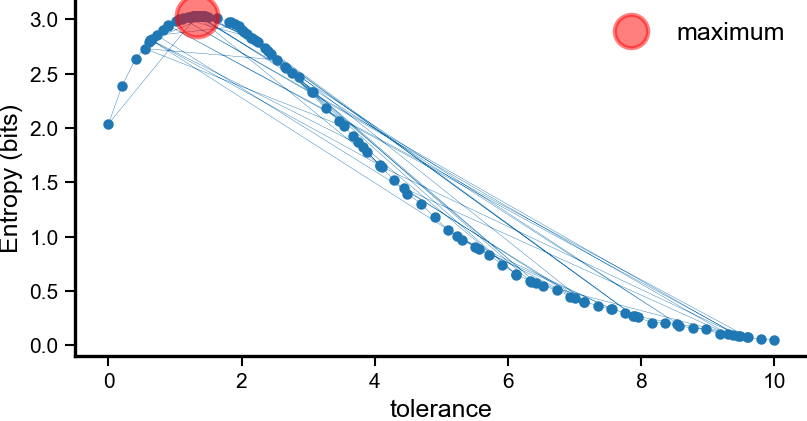

In [56]:
def show_optimization(trace, res, param='tolerance'):
    tols = [t['params'][param] for t in trace]
    scores = [t['score'] for t in trace]
    plt.plot(tols, scores, '.-', lw=.1)
    plt.plot([res.x], [-1*res.fun], 'ro', alpha=.5, ms=10, label='maximum')
    plt.ylabel('Entropy (bits)')
    plt.xlabel(param)
    plt.legend()
    sns.despine()

plt.figure(figsize=cm2inch(8, 4), dpi=150)
show_optimization(opt.optimizer.trace, opt.res)

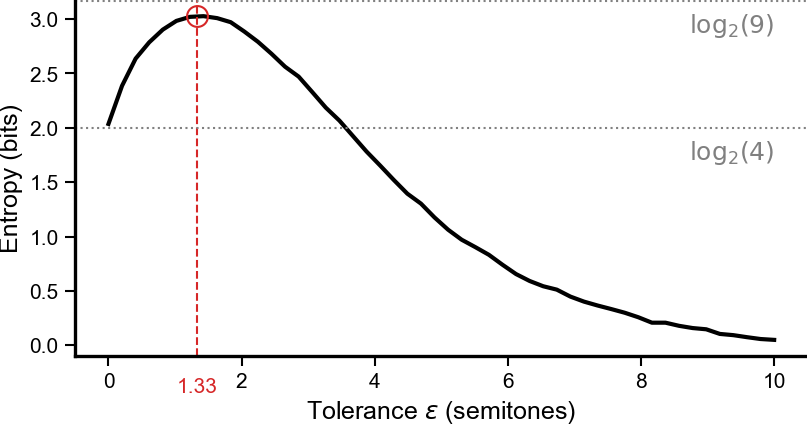

In [61]:
def decorate_entropy_plot(ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    plt.ylabel('Entropy (bits)')
    plt.xlabel('Tolerance $\epsilon$ (semitones)');
    plt.axhline(np.log2(4), ls=':', c='0.5', lw=.5)
    plt.text(10, np.log2(4)-.1, '$\log_2(4)$', 
            va='top', ha='right', c='0.5', fontsize=6)
    plt.axhline(np.log2(9), ls=':', c='0.5', lw=.5)
    plt.text(10, np.log2(9)-.1, '$\log_2(9)$', 
            va='top', ha='right', c='0.5', fontsize=6)
    sns.despine()

def show_entropy(xs, losses, best_epsilon, best_entropy, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)
    plt.plot(xs, losses, 'k-', lw=1)
    plt.plot(best_epsilon, best_entropy, 'o', markerfacecolor="None", ms=5, color='C3', markeredgewidth=.5)
    plt.axvline(best_epsilon, ls='--', color='C3', lw=.5, label='optimal $\epsilon$ for erk')
    plt.text(best_epsilon, -.3, f'{best_epsilon:.2f}', color='C3', va='top', ha='center', size=5)
    decorate_entropy_plot(ax=ax)

plt.figure(figsize=cm2inch(8,4), dpi=150)
show_entropy(opt.xs, opt.losses, opt.best_epsilon, opt.best_entropy)

## Entropy per tradition

In [60]:
dataset_ids = ['erk-phrase', 'han-phrase', 'liber-antiphons-phrase']
results = {}
for dataset_id in dataset_ids:
    cont = Dataset(dataset_id).contours('pitch_centered', limit=1000)
    cont = [Contour(c) for c in cont]
    results[dataset_id] = HuronOptimization(cont)

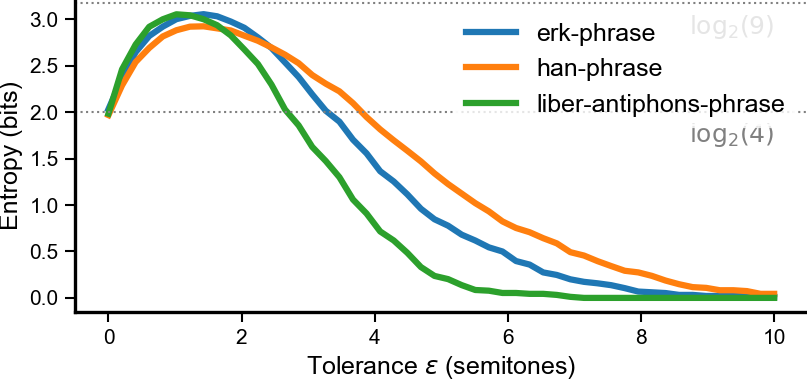

In [63]:
plt.figure(figsize=cm2inch(8, 3.5), dpi=150)
for dataset_id, experiment in results.items():
    plt.plot(experiment.xs, experiment.losses, label=dataset_id)
plt.legend()
decorate_entropy_plot()

## Panel A

In [37]:
order = {
    'descending': 'desc',
    'horizontal-descending': 'h-desc',
    'convex': 'convex',
    'descending-horizontal': 'desc-h',
    'horizontal': 'horiz',
    'ascending-horizontal': 'asc-h',
    'concave': 'concave',
    'ascending': 'asc',
    'horizontal-ascending': 'h-asc',
}

In [99]:
def get_type_freqs(contours, epsilons):
    distributions = np.zeros((len(epsilons), 9))
    for i, epsilon in enumerate(epsilons):
        T = HuronTypology(tolerance=epsilon)
        contour_types = [T.classify(c) for c in contours]
        freqs = pd.value_counts(contour_types, normalize=True)
        distributions[i, :] = [freqs.get(t, 0) for t in order.keys()]

    freqs = pd.DataFrame(distributions, index=epsilons, columns=order.keys()).T
    freqs.index.name = 'type'
    return freqs

,0.2,1.5,3.0
type,,,
descending,0.317,0.152,0.045
horizontal-descending,0.032,0.190,0.167
convex,0.321,0.140,0.051
descending-horizontal,0.029,0.118,0.111
horizontal,0.004,0.138,0.468
ascending-horizontal,0.033,0.113,0.095
concave,0.141,0.050,0.016
ascending,0.110,0.044,0.005
horizontal-ascending,0.013,0.055,0.042


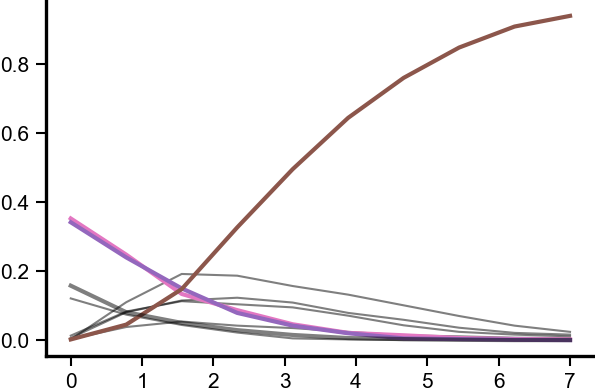

In [69]:
def show_freqs(epsilons, freqs):
    for label, ys in freqs.iterrows():
        if label not in ['horizontal', 'descending', 'convex', 'concave']:
            plt.plot(epsilons, ys, 'k-', lw=.5, ms=4, alpha=.5)
    plt.plot(epsilons, freqs.loc['convex', :], '-', lw=1, color='C6', label='convex')
    plt.plot(epsilons, freqs.loc['descending', :], '-', lw=1, color='C4', label='descending')
    plt.plot(epsilons, freqs.loc['horizontal', :], '-', lw=1, color='C5', label='horizontal')
    plt.plot(epsilons, freqs.loc['concave', :], 'k-', lw=1, ms=4, alpha=.5, label='others')

epsilons = np.linspace(0, 7, 10)
freqs = get_type_freqs(contours, epsilons)
plt.figure(figsize=cm2inch(6,4), dpi=150)
show_freqs(epsilons, freqs)

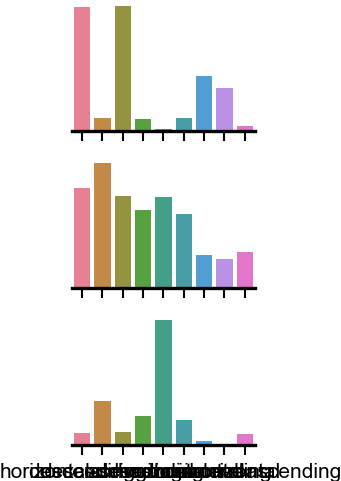

In [113]:
epsilons = [0.2, 1.5, 3]
fig, axs = plt.subplots(3, figsize=cm2inch(2, 5), sharex=True, dpi=150)
freqs = get_type_freqs(contours, epsilons).reset_index()
for ax, epsilon in zip(axs, epsilons):
    sns.barplot(data=freqs, x='type', y=epsilon, ax=ax, palette='husl')    
    sns.despine(left=True, ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')

In [118]:
import umap
import umap.plot

In [119]:
cont = dataset.contours('pitch_centered', limit=1000)
mapper = umap.UMAP().fit(cont)

In [121]:
labels = {}
for eps in epsilons:
    T = HuronTypology(tolerance=eps)
    labels[eps] = np.array([T.classify(Contour(c)) for c in cont])

In [123]:
umap.plot.points?

Signature:
umap.plot.points(
    umap_object,
    labels=None,
    values=None,
    theme=None,
    cmap='Blues',
    color_key=None,
    color_key_cmap='Spectral',
    background='white',
    width=800,
    height=800,
    show_legend=True,
    subset_points=None,
    ax=None,
    alpha=None,
)
Docstring:
Plot an embedding as points. Currently this only works
for 2D embeddings. While there are many optional parameters
to further control and tailor the plotting, you need only
pass in the trained/fit umap model to get results. This plot
utility will attempt to do the hard work of avoiding
overplotting issues, and make it easy to automatically
colour points by a categorical labelling or numeric values.

This method is intended to be used within a Jupyter
notebook with ``%matplotlib inline``.

Parameters
----------
umap_object: trained UMAP object
    A trained UMAP object that has a 2D embedding.

labels: array, shape (n_samples,) (optional, default None)
    An array of labels (assumed 

<AxesSubplot:>

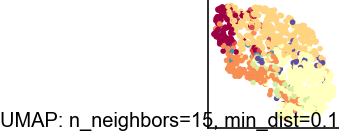

In [127]:
plt.figure(figsize=cm2inch(3, 3))
umap.plot.points(mapper, labels[0.2], ax=plt.gca(), show_legend=False)

<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

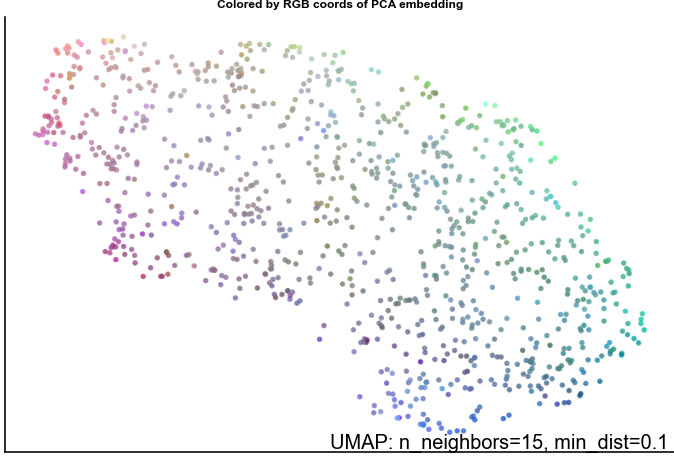

In [129]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

## Entropy panel

In [136]:
loss_fn = huron_optimizer.loss_function(erk_contours[:1000], ['tolerance'])
xs = np.linspace(0, epsilons[-1], 100)
losses = [-1*loss_fn([x]) for x in xs]

In [145]:
best, res = huron_optimizer.optimize(erk_contours[:1000], dict(tolerance=[0, 10]))
best_entropy = -1*res['fun']
best_epsilon = best['tolerance']

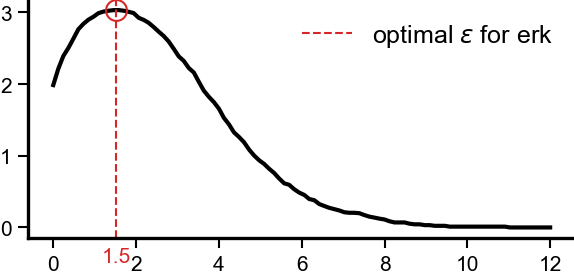

In [167]:
def show_entropy(xs, losses, best_epsilon, best_entropy):
    plt.plot(xs, losses, 'k-', lw=1)
    plt.plot(best_epsilon, best_entropy, 'o', markerfacecolor="None", ms=5, color='C3', markeredgewidth=.5)
    plt.axvline(best_epsilon, ls='--', color='C3', lw=.5, label='optimal $\epsilon$ for erk')
    plt.gca().text(best_epsilon, -.27, f'{best_epsilon:.1f}', color='C3', va='top', ha='center', size=5)
    plt.legend()

plt.figure(figsize=(2,1))
show_entropy(xs, losses, best_epsilon, best_entropy)

In [169]:
## Panel B

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


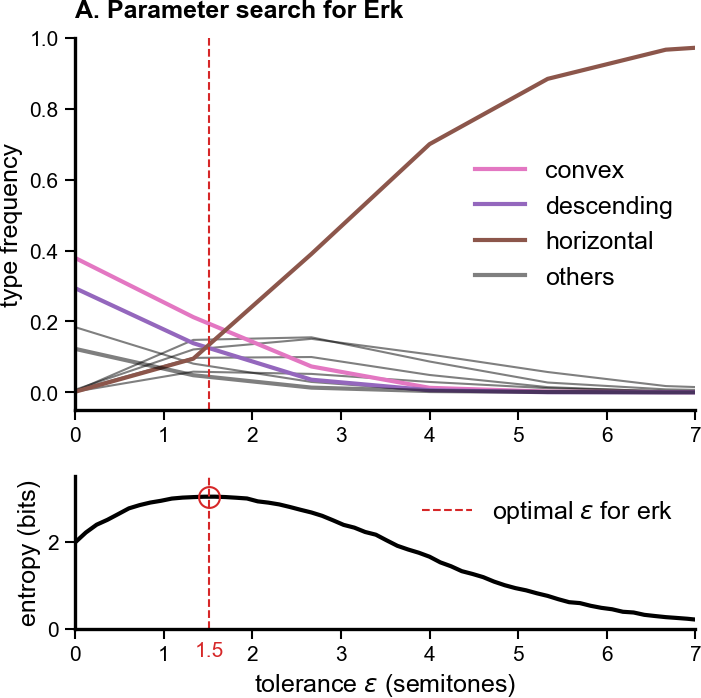

In [166]:
plt.figure(figsize=cm2inch(12,6.5))

# Frequencies
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
show_freqs(epsilons, freqs)
plt.axvline(best_epsilon, ls='--', color='C3', lw=.5)
plt.ylim(-.05, 1)
plt.xlim(0, 7)
plt.ylabel('type frequency')
plt.title('A. Parameter search for Erk', ha='left', x=0)
plt.legend()

ax2 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
show_entropy(xs, losses, best_epsilon, best_entropy)
plt.ylim(0, 3.5)
plt.ylabel('entropy (bits)')
plt.xlabel('tolerance $\epsilon$ (semitones)')

plt.tight_layout()

# TODO: CONTINUE HERE: ADD THE BAR PLOTS

In [ ]:
def bar_plot(tolerance, dataset_id='erk',
                width=.2, delta=0, label=None, color=None,
                param_search=all_param_search):
    if tolerance == 'optimal':
        tolerance = param_search[dataset_id]['tolerance'] 
    index = param_search[dataset_id]['tolerances'].index(tolerance)
    freqs = np.array(param_search[dataset_id]['frequencies'])[:, index]
    plt.bar(np.arange(9) + delta, freqs, width=width, label=label, color=color)
    plt.xticks([])